### Figure 5: Power Spectra at each wave number

In [1]:
import numpy as np
from esda.moran import Moran,Moran_Local
from libpysal.weights import lat2W
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import properscoring as ps
import warnings
from scipy import stats
import scipy.stats as stats
from scipy import interpolate
# from utils.evaluation import plot_histogram,calc_peak,calc_mean
# https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
from sklearn.metrics import mean_squared_error
from math import sqrt
from utils.data import load_tc_data
import xesmf as xe
warnings.filterwarnings("ignore")
# sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

# TODO: plot all ensemble members individually

/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def power_spectrum_dB(img):
	fx = np.fft.fft2(img)
	fx = fx[:img.shape[0]//2, :img.shape[1]//2] # disgard half of it because you can derive one half from the other?
	px = abs(fx)**2 # get the size of the amplitudes
	return 10 * np.log10(px) # is this the rainfall normalisation step?

def power_spectrum_dB_2(img):
	fx = np.fft.fft2(img)
	# fx = fx[:img.shape[0]//2, :img.shape[1]//2] # disgard half of it because you can derive one half from the other?
	px = abs(fx)**2 # get the size of the amplitudes
	return px

def log_spectral_batch(batch1):
	lsd_batch = []
	for i in range(batch1.shape[0]):
		lsd = power_spectrum_dB_2(
				batch1[i, :, :])
		lsd_batch.append(lsd)
	return np.array(lsd_batch)

In [3]:
model = ''
# set mode
mode = 'validation'

# load datasets
real,inputs,pred_unet,pred_vaegan,pred_gan,pred_vaegan_ensemble,pred_gan_ensemble,meta = load_tc_data(set='test',results='test')
real_x,inputs_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x,meta_extreme_valid = load_tc_data(set='extreme_test',results='test')
# inputs = np.load('/user/home/al18709/work/gan_predictions_20/validation_input-opt_improve.npy')[:,:,:,0]
hrmip = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3p/historical/storm_rain.npy')[-28000:]

# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)
hrmip_hr = regridder(hrmip)
inputs_x_hr = regridder(inputs_x)

In [4]:
lsb_real = log_spectral_batch(real)
lsb_gan = log_spectral_batch(pred_gan)
lsb_vaegan = log_spectral_batch(pred_vaegan)
lsb_unet = log_spectral_batch(pred_unet)
lsb_inputs = log_spectral_batch(inputs_hr)
print(lsb_real[0])


[[1.50685653e+09 2.57970571e+08 6.96471542e+06 ... 1.27502351e+06
  6.96471542e+06 2.57970571e+08]
 [2.59361410e+08 3.86100282e+07 2.04756675e+07 ... 4.38802764e+06
  3.41725480e+07 1.56774866e+08]
 [3.47293890e+07 6.65609177e+06 4.05291144e+06 ... 3.18180060e+06
  3.12351687e+07 1.11472014e+07]
 ...
 [1.52750209e+07 1.70913475e+07 6.41234860e+06 ... 5.98314220e+06
  4.29148431e+06 7.82599281e+06]
 [3.47293890e+07 1.11472014e+07 3.12351687e+07 ... 9.37169873e+05
  4.05291144e+06 6.65609177e+06]
 [2.59361410e+08 1.56774866e+08 3.41725480e+07 ... 1.92670630e+06
  2.04756675e+07 3.86100282e+07]]


In [5]:
def plot_power_spectrum(spectral_density,plot=True):
    """
    spectral density should probably be a 100x100 image
    """
	# https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
    npix=100

    # return a one dimensional array containing the wave vectors for the numpy.fft.fftn call, in the correct order.
    kfreq = np.fft.fftfreq(npix) * npix
    
    # convert this to a two dimensional array matching the layout of the two dimensional Fourier image, we can use numpy.meshgrid
    kfreq2D = np.meshgrid(kfreq, kfreq)
    
    # Finally, we are not really interested in the actual wave vectors, but rather in their norm
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    # we no longer need the wave vector norms or Fourier image to be laid out as a two dimensional array, so we will flatten them
    knrm = knrm.flatten()
    fourier_amplitudes = spectral_density
    fourier_amplitudes = fourier_amplitudes.flatten()

    # bin the amplitudes in k space, we need to set up wave number bins
    # Note that the maximum wave number will equal half the pixel size of the image. 
    # This is because half of the Fourier frequencies can be mapped back to negative wave
    #  numbers that have the same norm as their positive counterpart.
    kbins = np.arange(0.5, npix//2+1, 1.)

    # The kbin array will contain the start and end points of all bins; the corresponding k values are the midpoints of these bins
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    # To compute the average Fourier amplitude (squared) in each bin, we can use scipy.stats
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                        statistic = "mean",
                                        bins = kbins)

    # Remember that we want the total variance within each bin. Right now, we only have the average power. To get the total power, we need to multiply with the volume in each bin (in 2D, this volume is actually a surface area)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

    if plot == True:
        plt.loglog(kvals, Abins)
        plt.show
    else:
        return kvals,Abins
    

In [6]:

def calc_power(lsb_pred):
	kvals_list = []
	Abins_list = []

	for lsb in lsb_pred:
		kvals,Abins = plot_power_spectrum(lsb,plot=False)
		kvals_list.append(kvals)
		Abins_list.append(Abins)

	kvals = np.array(kvals_list)
	Abins = np.array(Abins_list)
	return kvals,Abins


In [7]:
kvals_real,Abins_real = calc_power(lsb_real)
kvals_gan,Abins_gan = calc_power(lsb_gan)
kvals_vaegan,Abins_vaegan = calc_power(lsb_vaegan)
kvals_unet,Abins_unet = calc_power(lsb_unet)
kvals_inputs,Abins_inputs = calc_power(lsb_inputs)

In [8]:

def mean_power(kvals,Abins):

	xnew = np.sort(kvals.flatten())
	Y = np.zeros((Abins.shape[0],len(xnew)))
	for i,y in enumerate(Abins):
		x = kvals[i]	
		f = interpolate.interp1d(x, y,bounds_error=False)
		ynew = f(xnew)
		print(ynew.shape)
		print('xnew shape',xnew.shape)
		Y[i] = ynew
	print(xnew.shape)
	print(Y.shape)
	# split up to process the mean
	Y_mean_1 = np.nanmean(Y[0:5000],axis=0)
	Y_mean_2 = np.nanmean(Y[5000:10000],axis=0)
	Y_mean_3 = np.nanmean(Y[10000:],axis=0)
	Y_mean = np.nanmean([Y_mean_1,Y_mean_2,Y_mean_3],axis=0)
	print(Y_mean.shape)
	# kvals = x, Abins = Y_mean
	return(xnew,Y_mean)


In [9]:
# plt.plot(xnew,Y_mean)
# k,p_k = mean_power(kvals,Abins)
# TODO: this takes way too long
print(kvals_real[0])
print(kvals_real[1])
k_real,p_k_real = kvals_real[0],np.mean(Abins_real,axis=0)
k_gan,p_k_gan = kvals_gan[0],np.mean(Abins_gan,axis=0)
k_vaegan,p_k_vaegan = kvals_vaegan[0],np.mean(Abins_vaegan,axis=0)
k_unet,p_k_unet = kvals_unet[0],np.mean(Abins_unet,axis=0)
k_inputs,p_k_inputs = kvals_inputs[0],np.mean(Abins_inputs,axis=0)


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]


In [10]:
k_gan_ensemble = np.zeros((20,50))
k_vaegan_ensemble = np.zeros((20,50))
p_k_gan_ensemble = np.zeros((20,50))
p_k_vaegan_ensemble = np.zeros((20,50))
for i in range(20):
	lsb_vaegan_i = log_spectral_batch(pred_vaegan_ensemble[:,:,:,i])
	lsb_gan_i = log_spectral_batch(pred_gan_ensemble[:,:,:,i])
	kvals_vaegan_i,Abins_vaegan_i = calc_power(lsb_vaegan_i)
	kvals_gan_i,Abins_gan_i = calc_power(lsb_gan_i)
	k_gan,p_k_gan = kvals_gan[0],np.mean(Abins_gan,axis=0)
	k_vaegan_i,p_k_vaegan_i = kvals_vaegan[0],np.mean(Abins_vaegan_i,axis=0)
	k_gan_i,p_k_gan_i = kvals_gan[0],np.mean(Abins_gan_i,axis=0)
	k_gan_ensemble[i,:] = k_gan_i
	p_k_gan_ensemble[i,:] = p_k_gan_i
	k_vaegan_ensemble[i,:] = k_vaegan_i
	p_k_vaegan_ensemble[i,:] = p_k_vaegan_i
	

In [11]:
print(p_k_vaegan_ensemble.shape)

k_vaegan_min,p_k_vaegan_min = k_vaegan_ensemble[0],np.min(p_k_vaegan_ensemble,axis=0)
k_vaegan_max,p_k_vaegan_max = k_vaegan_ensemble[0],np.max(p_k_vaegan_ensemble,axis=0)
k_gan_min,p_k_gan_min = k_gan_ensemble[0],np.min(p_k_gan_ensemble,axis=0)
k_gan_max,p_k_gan_max = k_gan_ensemble[0],np.max(p_k_gan_ensemble,axis=0)

k_vaegan_ensemble,p_k_vaegan_ensemble = k_vaegan_ensemble[0],np.mean(p_k_vaegan_ensemble,axis=0)
k_gan_ensemble,p_k_gan_ensemble = k_gan_ensemble[0],np.mean(p_k_gan_ensemble,axis=0)


# k_vaegan_min,p_k_vaegan_min = k_vaegan_ensemble[0],p_k_vaegan_ensemble - p_k_vaegan_std
# k_gan_min,p_k_gan_min = k_gan_ensemble[0],p_k_gan_ensemble - p_k_gan_std

# k_vaegan_max,p_k_vaegan_max = k_vaegan_ensemble[0],p_k_vaegan_ensemble + p_k_vaegan_std
# k_gan_max,p_k_gan_max = k_gan_ensemble[0],p_k_gan_ensemble + p_k_gan_std


(20, 50)


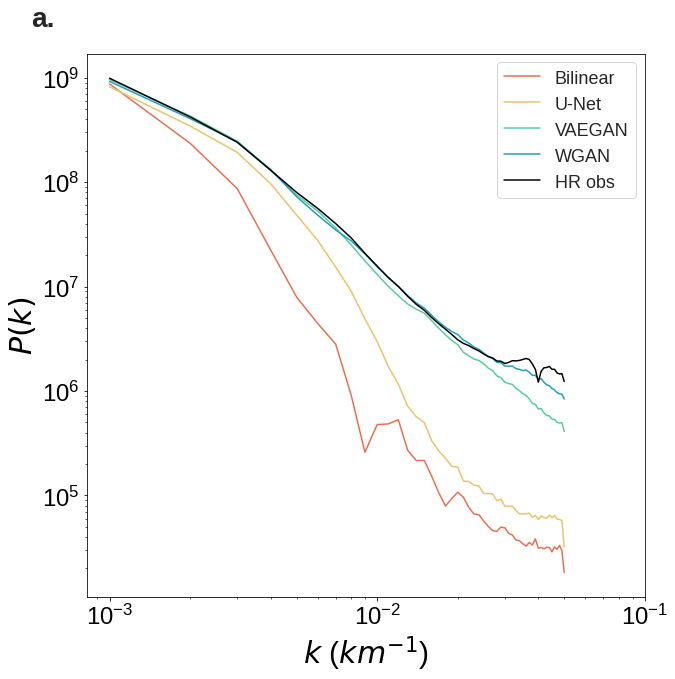

In [12]:
# Most power is located at large scales - small wave numbers. Does this make sense? This would mean most of the 
# image is dominated by large structures i.e. the core?
# Towards smaller scales (larger wave numbers) the power drops off suddenly and in a linear (but it is a log scale? I guess it is a 
# double log) fashion. This is an expression of the fractal nature of the TC: at lower resolutions the same types of patterns return, 
# but at increasingly lower signal. There is a huge spike in the power spectrum at a wave number of ~300, or a size scale of about 3 
# pixels. This is the scale at which the smallest rainfall features at the edges of the large features manifest.
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharey=False)
plt.style.use('seaborn-ticks')
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context("notebook")
# print(k)
# print(p_k)
def change_units(x):
	# npix * 1/k gives the units of pixels on the x axis
	# then we multiply by 10 because each pixel is 10km, the whole image is 1000km across
	# return 1000/x
	return x/1000
plt.loglog(change_units(k_inputs),p_k_inputs,color='#e76f51')
plt.loglog(change_units(k_unet),p_k_unet,color='#e9c46a')
# plt.loglog(k_vaegan,p_k_vaegan,color='#57cc99')
# plt.loglog(k_gan,p_k_gan,color='#219ebc')
plt.loglog(change_units(k_vaegan_ensemble),p_k_vaegan_ensemble,color='#57cc99')
plt.loglog(change_units(k_gan_ensemble),p_k_gan_ensemble,color='#219ebc')

# plt.loglog(k_gan_ensemble[0],p_k_gan_ensemble[0],color='#219ebc')
# plt.loglog(k_gan_ensemble[1],p_k_gan_ensemble[1],color='#219ebc')
# plt.loglog(k_gan_ensemble[2],p_k_gan_ensemble[2],color='#219ebc')
# plt.loglog(k_gan_ensemble[3],p_k_gan_ensemble[3],color='#219ebc')
# plt.loglog(k_gan_ensemble[4],p_k_gan_ensemble[4],color='#219ebc')
axes.text(-0.1, 1.05, 'a.', transform=axes.transAxes, size=28, weight='bold')
plt.loglog(change_units(k_real),p_k_real,color='black')
plt.xlabel("$k$ ($km^{-1}$)",fontsize=30)
plt.xlim([0,0.1])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel("$P(k)$",fontsize=30)
plt.legend(['Bilinear','U-Net','VAEGAN','WGAN','HR obs'],frameon=True,fontsize=18)
# plt.fill_between(k_vaegan_ensemble, p_k_vaegan_min,p_k_vaegan_max,color='#57cc99',alpha=0.2)
# plt.fill_between(k_gan_ensemble, p_k_gan_min,p_k_gan_max,color='#219ebc',alpha=0.2)
plt.savefig('figure5-power_spectra-test-new.png',bbox_inches='tight',dpi=600)
# plt.show

In [13]:
# The unet and the hr_input images are blurrier than their real contourparts. We can see this in the power spectra graph as 
# the power spectra drops off when the wave numnber is around 2. The images lose details as we sample smaller pixel areas.

In [14]:
print(p_k_gan_max)
# print(p_k_gan_min)
print(p_k_gan_ensemble)
# print(p_k_gan_std)

[9.24851955e+08 4.07661326e+08 2.44764030e+08 1.32745988e+08
 7.30592314e+07 4.85853558e+07 3.50678177e+07 2.75690385e+07
 2.07354026e+07 1.57436343e+07 1.23093825e+07 1.01650987e+07
 8.30800635e+06 7.03147386e+06 6.25895782e+06 5.33580438e+06
 4.62315495e+06 4.11607962e+06 3.75763048e+06 3.50600502e+06
 3.10213716e+06 2.89837770e+06 2.66250452e+06 2.52065890e+06
 2.32740942e+06 2.15820555e+06 2.06238142e+06 1.90026491e+06
 1.87904069e+06 1.74707752e+06 1.74331004e+06 1.74903262e+06
 1.64714532e+06 1.62510995e+06 1.57950125e+06 1.60339693e+06
 1.52991287e+06 1.42469830e+06 1.42626442e+06 1.30627347e+06
 1.32010681e+06 1.21910980e+06 1.15346619e+06 1.13051478e+06
 1.06297868e+06 1.03419661e+06 9.73729457e+05 9.48052549e+05
 9.40669220e+05 8.44434322e+05]
[9.24445200e+08 4.07306222e+08 2.44335570e+08 1.32451026e+08
 7.27082015e+07 4.83421545e+07 3.48614758e+07 2.74146325e+07
 2.06194116e+07 1.56028394e+07 1.21715340e+07 1.00435599e+07
 8.22580619e+06 6.97247364e+06 6.21685153e+06 5.29133

In [15]:
# p_k_vaegan_std

In [16]:
inputs_x_max = np.max(inputs_x,axis=(1,2))
max_idx = list(np.argpartition(inputs_x_max, -100)[-100:])
pred_vaegan_x = pred_vaegan_x[max_idx]
pred_gan_x = pred_gan_x[max_idx]
real_x = real_x[max_idx]
pred_vaegan_ensemble_x = pred_vaegan_ensemble_x[max_idx]
pred_gan_ensemble_x = pred_gan_ensemble_x[max_idx]
inputs_hr_x = inputs_x_hr[max_idx]
pred_cnn_x = pred_cnn_x[max_idx]

In [17]:
lsb_real = log_spectral_batch(real_x)
lsb_gan = log_spectral_batch(pred_gan_x)
lsb_vaegan = log_spectral_batch(pred_vaegan_x)
lsb_unet = log_spectral_batch(pred_cnn_x)
lsb_inputs = log_spectral_batch(inputs_x_hr)

kvals_real,Abins_real = calc_power(lsb_real)
kvals_gan,Abins_gan = calc_power(lsb_gan)
kvals_vaegan,Abins_vaegan = calc_power(lsb_vaegan)
kvals_unet,Abins_unet = calc_power(lsb_unet)
kvals_inputs,Abins_inputs = calc_power(lsb_inputs)

k_real,p_k_real = kvals_real[0],np.mean(Abins_real,axis=0)
k_gan,p_k_gan = kvals_gan[0],np.mean(Abins_gan,axis=0)
k_vaegan,p_k_vaegan = kvals_vaegan[0],np.mean(Abins_vaegan,axis=0)
k_unet,p_k_unet = kvals_unet[0],np.mean(Abins_unet,axis=0)
k_inputs,p_k_inputs = kvals_inputs[0],np.mean(Abins_inputs,axis=0)

In [18]:
k_gan_ensemble = np.zeros((20,50))
k_vaegan_ensemble = np.zeros((20,50))
p_k_gan_ensemble = np.zeros((20,50))
p_k_vaegan_ensemble = np.zeros((20,50))
for i in range(20):
	lsb_vaegan_i = log_spectral_batch(pred_vaegan_ensemble_x[:,:,:,i])
	lsb_gan_i = log_spectral_batch(pred_gan_ensemble_x[:,:,:,i])
	kvals_vaegan_i,Abins_vaegan_i = calc_power(lsb_vaegan_i)
	kvals_gan_i,Abins_gan_i = calc_power(lsb_gan_i)
	k_gan,p_k_gan = kvals_gan[0],np.mean(Abins_gan,axis=0)
	k_vaegan_i,p_k_vaegan_i = kvals_vaegan[0],np.mean(Abins_vaegan_i,axis=0)
	k_gan_i,p_k_gan_i = kvals_gan[0],np.mean(Abins_gan_i,axis=0)
	k_gan_ensemble[i,:] = k_gan_i
	p_k_gan_ensemble[i,:] = p_k_gan_i
	k_vaegan_ensemble[i,:] = k_vaegan_i
	p_k_vaegan_ensemble[i,:] = p_k_vaegan_i

In [19]:
k_vaegan_min,p_k_vaegan_min = k_vaegan_ensemble[0],np.min(p_k_vaegan_ensemble,axis=0)
k_vaegan_max,p_k_vaegan_max = k_vaegan_ensemble[0],np.max(p_k_vaegan_ensemble,axis=0)
k_gan_min,p_k_gan_min = k_gan_ensemble[0],np.min(p_k_gan_ensemble,axis=0)
k_gan_max,p_k_gan_max = k_gan_ensemble[0],np.max(p_k_gan_ensemble,axis=0)

k_vaegan_ensemble,p_k_vaegan_ensemble = k_vaegan_ensemble[0],np.mean(p_k_vaegan_ensemble,axis=0)
k_gan_ensemble,p_k_gan_ensemble = k_gan_ensemble[0],np.mean(p_k_gan_ensemble,axis=0)

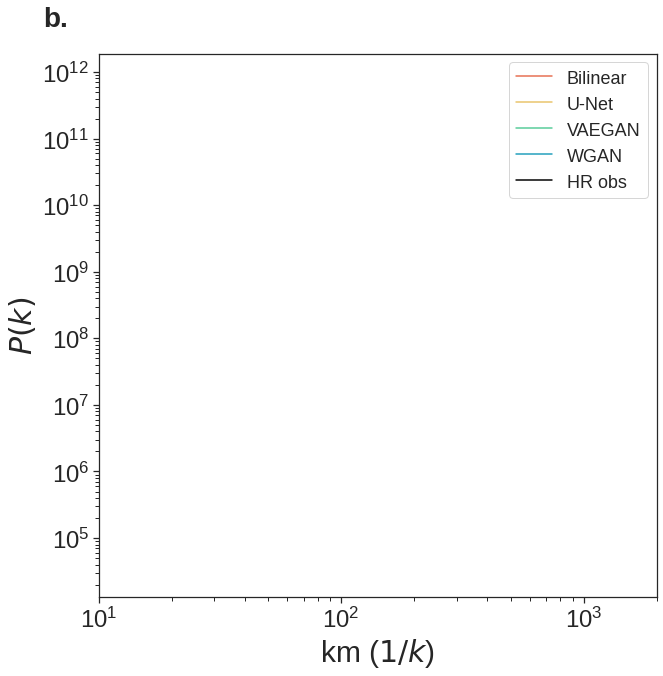

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharey=False)
plt.style.use('seaborn-ticks')
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context("notebook")
# print(k)
# print(p_k)
plt.loglog(change_units(k_inputs),p_k_inputs,color='#e76f51')
plt.loglog(change_units(k_unet),p_k_unet,color='#e9c46a')
plt.loglog(change_units(k_vaegan_ensemble),p_k_vaegan_ensemble,color='#57cc99')
plt.loglog(change_units(k_gan_ensemble),p_k_gan_ensemble,color='#219ebc')
# plt.loglog(k_gan_ensemble[0],p_k_gan_ensemble[0],color='#219ebc')
plt.loglog(change_units(k_real),p_k_real,color='black')
axes.text(-0.1, 1.05, 'b.', transform=axes.transAxes, size=28, weight='bold')

# plt.xlim([10,2000])
# plt.xlabel("km ($1 / k$)",fontsize=30)
plt.xlabel("$k$ ($km^{-1}$)",fontsize=30)
plt.xlim([0,0.1])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel("$P(k)$",fontsize=30)
plt.legend(['Bilinear','U-Net','VAEGAN','WGAN','HR obs'],frameon=True,fontsize=18)
# plt.fill_between(k_vaegan_ensemble, p_k_vaegan_min,p_k_vaegan_max,color='#57cc99',alpha=0.2)
# plt.fill_between(k_gan_ensemble, p_k_gan_min,p_k_gan_max,color='#219ebc',alpha=0.2)
plt.savefig('figure5-power_spectra-test-extreme_new.png',bbox_inches='tight',dpi=600)

In [28]:
# print(change_units(k_inputs),p_k_inputs)
# print(change_units(k_unet),p_k_unet)
# print(change_units(k_vaegan_ensemble),p_k_vaegan_ensemble)
# print(change_units(k_gan_ensemble),p_k_gan_ensemble)
print(change_units(k_real),p_k_real)

[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023 0.024
 0.025 0.026 0.027 0.028 0.029 0.03  0.031 0.032 0.033 0.034 0.035 0.036
 0.037 0.038 0.039 0.04  0.041 0.042 0.043 0.044 0.045 0.046 0.047 0.048
 0.049 0.05 ] [8.96377789e+09 5.36590441e+09 3.24807433e+09 1.84200366e+09
 9.47560257e+08 6.05773409e+08 4.20738211e+08 3.05418670e+08
 2.38447082e+08 1.92305386e+08 1.51493728e+08 1.24475838e+08
 1.00273073e+08 8.57757082e+07 7.64426940e+07 6.72972483e+07
 6.51422397e+07 5.99429077e+07 5.81221067e+07 5.63390795e+07
 5.07421957e+07 5.15507570e+07 4.44296409e+07 4.13963110e+07
 3.76028802e+07 3.30801706e+07 3.08328516e+07 2.94034431e+07
 2.97570947e+07 2.93170063e+07 2.90539163e+07 2.89558386e+07
 2.79699983e+07 2.77538835e+07 2.76912483e+07 2.76412014e+07
 2.68891342e+07 2.49219970e+07 2.39586856e+07 2.16855184e+07
 2.31821729e+07 2.34097837e+07 2.31761427e+07 2.29860153e+07
 2.18339497e+07 2.21626